# Imaging Data CCF files 
- Project/MAT/'mat files'

In [1]:
import scipy.io

#Projection zones file
mat = scipy.io.loadmat('../MAT/medialALM_mask_150um3Dgauss_Bilateral.mat')
vox = mat['F_smooth']

In [2]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import pandas as pd
%pip install nibabel
import nibabel as nib
plt.style.use('seaborn-poster')

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pyparsing>=2.0.2 in g:\anaconda\lib\site-packages (from packaging>=17->nibabel) (3.0.4)



# Prepping Data

In [3]:
import glob
from pynwb import NWBHDF5IO, NWBFile, TimeSeries
import ast

Subject_name = 'M440959'

# Storing Each sessions NWB OBJECT into array to access it without opening it everytime

nwb_files = glob.glob("..\%s\*.nwb"%(Subject_name))
nwb_io = []
# Iterate over each Session path in nwb_files
for name in nwb_files:
    io = NWBHDF5IO(name, mode="r").read()
    nwb_io.append(io)
    
pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop = [],[],[],[],[],[],[],[]
for name in nwb_files:  
    with NWBHDF5IO(name, "r") as io:
        read_nwbfile = io.read()
        pre_start.append(read_nwbfile.acquisition["BehavioralEvents"]["presample_start_times"].timestamps[:])
        pre_stop.append(read_nwbfile.acquisition["BehavioralEvents"]["presample_stop_times"].timestamps[:])
        sample_start.append(read_nwbfile.acquisition["BehavioralEvents"]["sample_start_times"].timestamps[:])
        sample_stop.append(read_nwbfile.acquisition["BehavioralEvents"]["sample_stop_times"].timestamps[:])
        delay_start.append(read_nwbfile.acquisition["BehavioralEvents"]["delay_start_times"].timestamps[:])
        delay_stop.append(read_nwbfile.acquisition["BehavioralEvents"]["delay_stop_times"].timestamps[:])
        go_start.append(read_nwbfile.acquisition["BehavioralEvents"]["go_start_times"].timestamps[:])
        go_stop.append(read_nwbfile.acquisition["BehavioralEvents"]["go_stop_times"].timestamps[:])
      
      
def Clean_data(pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop):
    for i in range(len(pre_start)):
        sample_start[i] = np.intersect1d(pre_stop[i], sample_start[i])
        sample_stop[i] = np.intersect1d(sample_stop[i], delay_start[i])
        delay_start[i] = np.intersect1d(delay_start[i], sample_stop[i])
        delay_stop[i] = np.intersect1d(delay_stop[i], go_start[i])
    return pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop

pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop = Clean_data(pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop)
 
    
#Get Trials dataframe for Every session(Only Selected(useful) columns) 
trials_df = []
for i in range(len(nwb_files)):
    trials_df.append(nwb_io[i].trials.to_dataframe().drop(['trial','task','trial_uid', 'photostim_power','photostim_duration','auto_water', 'free_water'],axis=1))
    trials_df[i] = trials_df[i].assign(pre_start = pre_start[i],
                         pre_stop = pre_stop[i],
                         sample_start = pre_stop[i],
                         sample_stop = sample_stop[i],
                         delay_start = delay_start[i],
                         delay_stop = delay_stop[i],
                         go_start = go_start[i],
                         go_stop = go_stop[i])
    trials_df[i]['ses_no'] = i+1
    
# Get Units dataframe for Every session    
units_df = []
for i in range(len(nwb_files)):
    units_df.append(nwb_io[i].units.to_dataframe())
    units_df[i]['ses_no'] = i+1
    units_df[i]['Region'] = units_df[i].electrodes.apply(lambda x: ast.literal_eval(x.location.values[0])['brain_regions'])

unit_result = pd.DataFrame()
trial_result = pd.DataFrame()

#Aggregating the Data
for i in range(len(nwb_files)):
    trial_result = pd.concat([trial_result, trials_df[i]])
    unit_result = pd.concat([unit_result, units_df[i]])

unit_result.Region.unique()

array(['left ALM', 'left Thalamus', 'left Midbrain'], dtype=object)

In [4]:
#Queries
trials_Data = trial_result.query("outcome == 'hit' ")  #photostim_onset == 'N/A' and 
trials_Data_L = trials_Data.query("early_lick == 'no early' ")
trials_Data_L = trials_Data_L.query(" ses_no == 2 ")
trials_Data_L

# ADDITIONAL QUERIES
# trials_Data = trials_Data.query(" (delay_stop - delay_start) > 1 and (delay_stop - delay_start) < 1.3")
# trials_Data = trials_Data.query(" (stop_time - start_time) < 5.3")
# trials_Data[ trials_Data['trial_instruction'] == 'left'].reset_index().query(" ses_no == 2 ")

,start_time,stop_time,photostim_onset,task_protocol,trial_instruction,early_lick,outcome,pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop,ses_no
id,,,,,,,,,,,,,,,,
0,0.0000,5.1223,N/A,1,left,no early,hit,0.5000,0.5100,0.5100,1.9283,1.9283,3.1283,3.1283,3.1783,2
1,6.9136,11.7023,N/A,1,left,no early,hit,7.4136,7.4236,7.4236,8.7712,8.7712,9.9712,9.9712,10.0212,2
2,13.5671,18.3250,N/A,1,left,no early,hit,14.0671,14.0771,14.0771,15.4221,15.4221,16.6221,16.6221,16.6721,2
3,20.1132,25.0088,N/A,1,left,no early,hit,20.6132,20.6232,20.6232,22.0057,22.0057,23.2057,23.2057,23.2557,2
7,47.0590,51.9274,N/A,1,right,no early,hit,47.5590,47.5690,47.5690,49.0310,49.0310,50.2310,50.2310,50.2810,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,3616.2004,3621.0991,N/A,1,left,no early,hit,3616.7004,3616.7104,3616.7104,3618.0980,3618.0980,3619.2980,3619.2980,3619.3480,2
511,3633.1094,3637.9340,N/A,1,left,no early,hit,3633.6094,3633.6194,3633.6194,3635.0440,3635.0440,3636.2440,3636.2440,3636.2940,2
512,3640.2459,3645.0135,1.917,1,right,no early,hit,3640.7459,3640.7559,3640.7559,3642.1629,3642.1629,3643.3629,3643.3629,3643.4129,2


In [5]:
unit_result.query(" Region == 'left ALM' and ses_no == 2")

,unit,sampling_rate,unit_quality,unit_posx,unit_posy,unit_amp,unit_snr,isi_violation,avg_firing_rate,drift_metric,...,anno_name,is_good_trials,spike_times,obs_intervals,electrodes,electrode_group,waveform_mean,waveform_sd,ses_no,Region
id,,,,,,,,,,,,,,,,,,,,,
0,0,30000,good,27.0,120.0,79.973083,3.839977,0.127551,4.577090,0.850966,...,,"[True, True, True, True, True, True, True, Tru...","[0.7801871832175418, 1.062222055991222, 1.6876...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",l...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[0.3791360294117647, 0.07878151260504201, 0.28...",[nan],2,left ALM
1,1,30000,good,59.0,120.0,133.676258,4.844900,1.000000,2.427770,0.313590,...,,"[True, True, True, True, True, True, True, Tru...","[11.048305879202925, 17.53857166907453, 17.598...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",l...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[1.4335808580858085, 0.7915635313531353, 0.363...",[nan],2,left ALM
2,2,30000,multi,27.0,160.0,98.935309,3.525485,0.261468,7.622420,0.590999,...,,"[True, True, True, True, True, True, True, Tru...","[0.09491677611656968, 0.16195047534217766, 0.3...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",l...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[-0.48589939024390244, -0.37633384146341464, -...",[nan],2,left ALM
3,3,30000,good,43.0,180.0,96.232888,3.391361,0.001715,6.522770,0.554765,...,,"[True, True, True, True, True, True, True, Tru...","[1.160889261216384, 2.781531440554946, 3.19526...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",l...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[-1.6336681166837257, -2.0031026100307066, -1....",[nan],2,left ALM
4,4,30000,good,27.0,200.0,92.239949,3.515121,0.021369,16.798500,0.296667,...,,"[True, True, True, True, True, True, True, Tru...","[0.027449741192337118, 0.04358316258726225, 0....","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",l...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[0.3945390781563127, -0.030529809619238478, 0....",[nan],2,left ALM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,183,30000,multi,59.0,2080.0,66.387195,2.532532,0.209699,2.890070,0.397529,...,,"[True, True, True, True, True, True, True, Tru...","[0.015116340539191864, 0.028983082895160717, 0...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[2.7843940548780486, 3.0130525914634148, 2.458...",[nan],2,left ALM
181,184,30000,multi,59.0,2080.0,113.495662,4.330282,0.202085,1.778400,0.361503,...,"Frontal pole, layer 5","[True, True, True, True, True, True, True, Tru...","[0.017749688246214923, 1.3704570717740165, 1.6...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[6.030658517350157, 5.133576498422713, 3.68197...",[nan],2,left ALM
182,185,30000,good,43.0,2180.0,90.684912,3.698110,0.000000,1.045400,0.470359,...,"Frontal pole, layer 5","[True, True, True, True, True, True, True, Tru...","[44.571768159347045, 54.24238618870378, 54.628...","[[0.0, 5.1223], [6.9136, 11.7023], [13.5671, 1...",...,17216703352 1-301 pynwb.ecephys.ElectrodeGroup...,"[3.4676955521472395, 3.5515720858895707, 2.777...",[nan],2,left ALM


In [6]:
unit_result.Region.value_counts()

left Thalamus    773
left Midbrain    397
left ALM         396
Name: Region, dtype: int64

In [7]:
bin_size = 1/200
trial_len = 5 #sec
data_points = trial_len/bin_size


'''
For both function

Input: Spike data(firing rate),sigma and other self explanatory inputs

Output: edges(time_vec), Gaussian smoothed Spike vector 

Process: Convert spike times into bins/vectors
- Use gaussian kernel to smooth the curves
'''
def plot_smooth_gauss(spike_data,sigma,color,dataset):
    hist, edges = np.histogram(np.hstack(spike_data), bins=(np.arange(data_points + 1)*bin_size - 1))
    freq = (hist/len(dataset))/bin_size
    width = np.diff(edges)
    smooth_gauss = []

    for i in edges[1:]:
        gauss = np.exp((- ( edges[1:] - i) ** 2) / ( 2 * (sigma**2) ) )
        gauss /=  sum(gauss)
        smooth_gauss.append(sum(gauss*freq))
    plt.plot(edges[1:],smooth_gauss,color=color)
    
def return_smooth_gauss(spike_data,sigma,dataset):
    hist, edges = np.histogram(np.hstack(spike_data), bins=(np.arange(data_points + 1)*bin_size - 1))
    freq = (hist/len(dataset))/bin_size
    width = np.diff(edges)
    smooth_gauss = []

    for i in edges[1:]:
        gauss = np.exp((- ( edges[1:] - i) ** 2) / ( 2 * (sigma**2) ) )
        gauss /=  sum(gauss)
        smooth_gauss.append(sum(gauss*freq))
    
    return freq,edges[1:],smooth_gauss

# Getting CCF locations and checking Overlapping with MAT files

In [10]:
units_Data = unit_result.query(" Region == 'left Thalamus' and ses_no == 1")

def get_ccf(unit_number):
    x = float(units_Data.electrodes[unit_number].reset_index().x.values)
    y = float(units_Data.electrodes[unit_number].reset_index().y.values)
    z = float(units_Data.electrodes[unit_number].reset_index().z.values)
    return x, y, z

In [24]:
x,y,z=[],[],[]
for i in list(units_Data.electrodes.reset_index().iloc[:,0]):
    try:
        x_ccf, y_ccf, z_ccf = get_ccf(i)
        x.append(x_ccf)
        y.append(y_ccf)
        z.append(z_ccf)

    # Some Units have missing CCF locations
    except Exception as err:
        x.append(0)
        y.append(0)
        z.append(0)

In [25]:
ccf_x = np.array(y)
ccf_y = np.array(x)
ccf_z = np.array(z)

In [26]:
len(ccf_x)

419

In [27]:
voxel_rd = 50      #Flexibility Criteria(Radius) for overlapping

r, c, v = np.where(vox >= 0.3)  #vox: First axis: dorsal-ventral, second axis: medial-lateral, third axis: anterior-posterior
r = r * 20
c = c * 20
v = v * 20

dorsal = np.where(ccf_y < 8000)[0]
frontal = np.where(ccf_z < 8000)[0]
frontal = np.intersect1d(dorsal, frontal)

Thalidx = []
#Condition for overlapping
for u in range(len(frontal)):
    for thal in range(len(c)):
        idx = frontal[u]
        if ccf_x[idx] >= r[thal] - voxel_rd and ccf_x[idx] < r[thal] + voxel_rd and ccf_y[idx] >= c[thal] - voxel_rd and ccf_y[idx] < c[thal] + voxel_rd and ccf_z[idx] >= v[thal] - voxel_rd and ccf_z[idx] < v[thal] + voxel_rd:
            Thalidx.append(idx)
            break

In [28]:
len(Thalidx),len(r),len(dorsal),len(ccf_x)             #129 @0.1 #44 @ 0.2 #35 @0.3 #0 @0.5

(0, 729368, 419, 419)

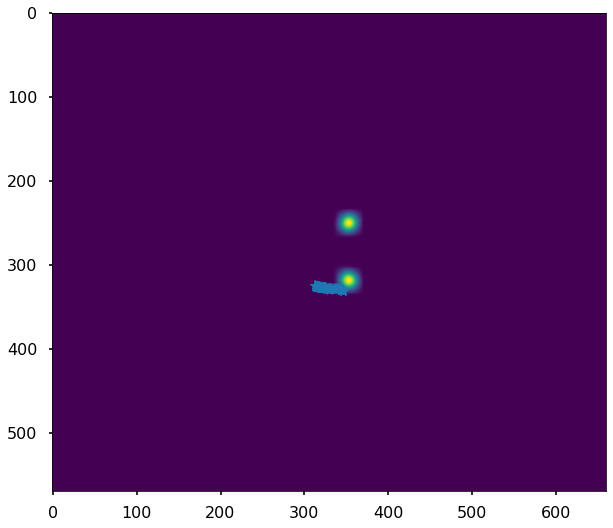

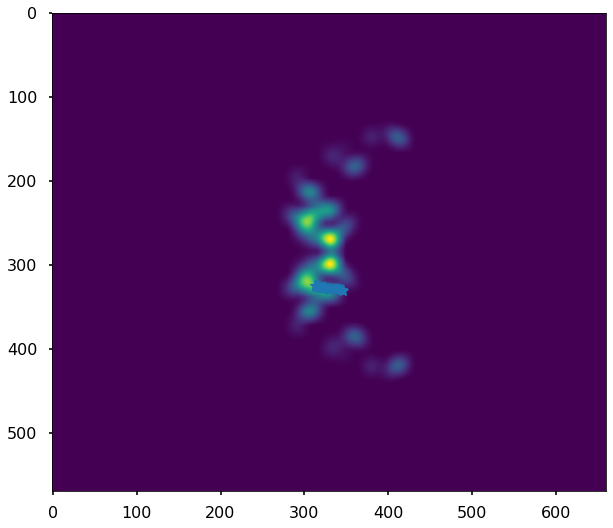

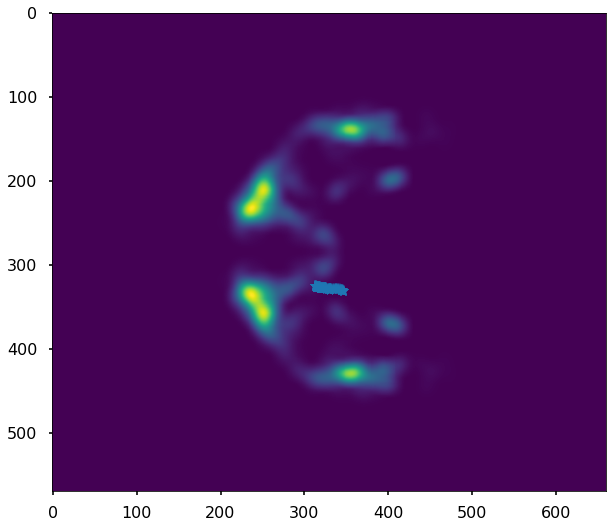

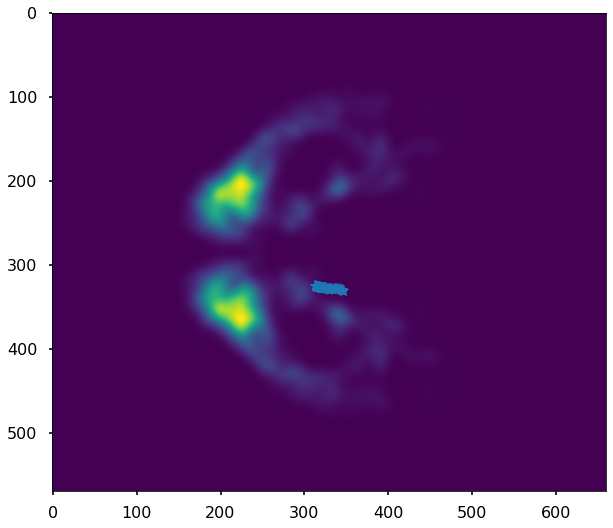

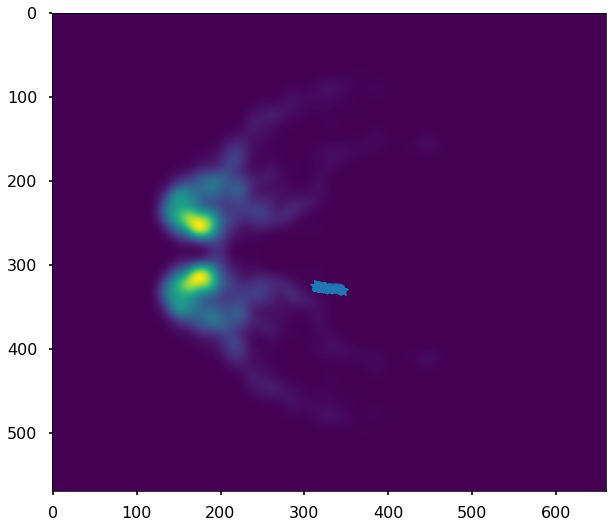

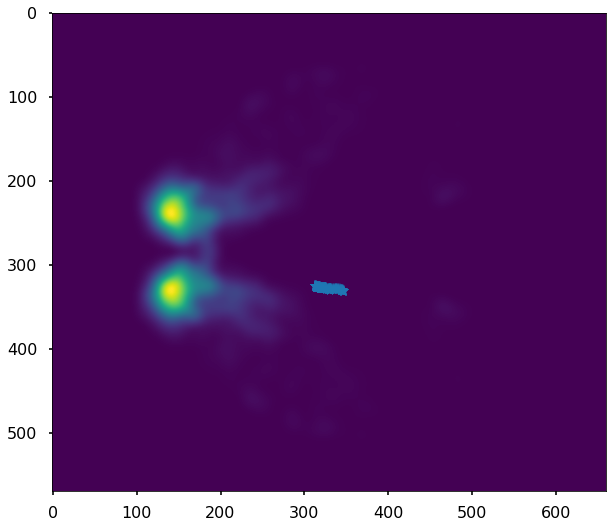

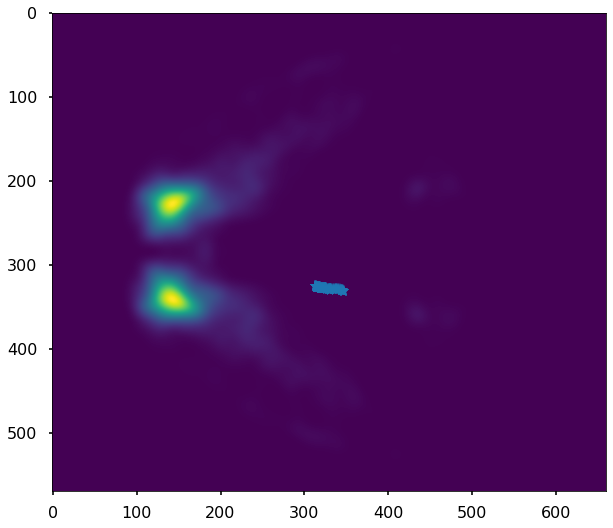

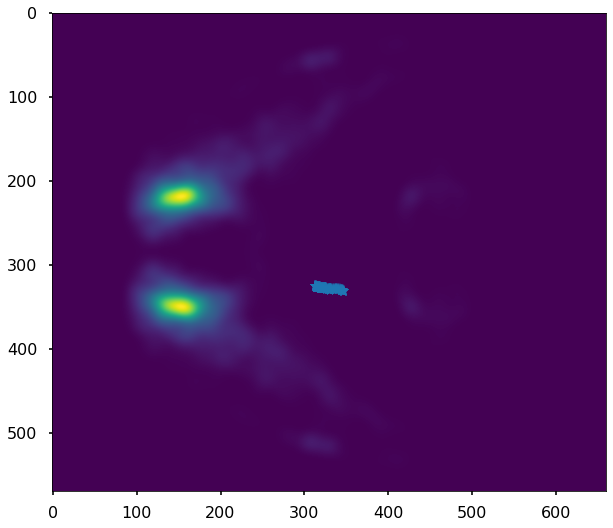

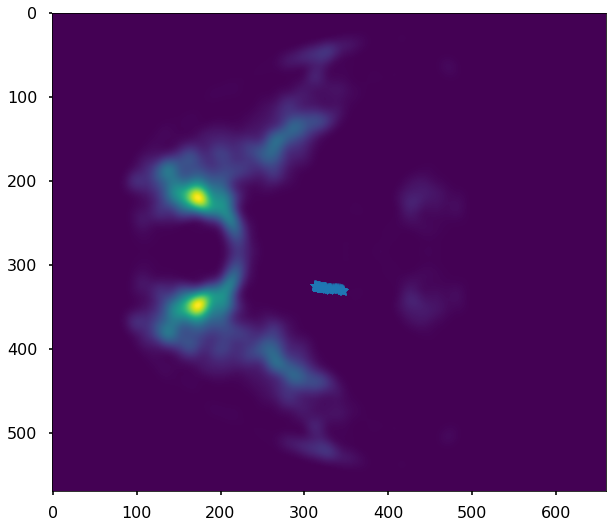

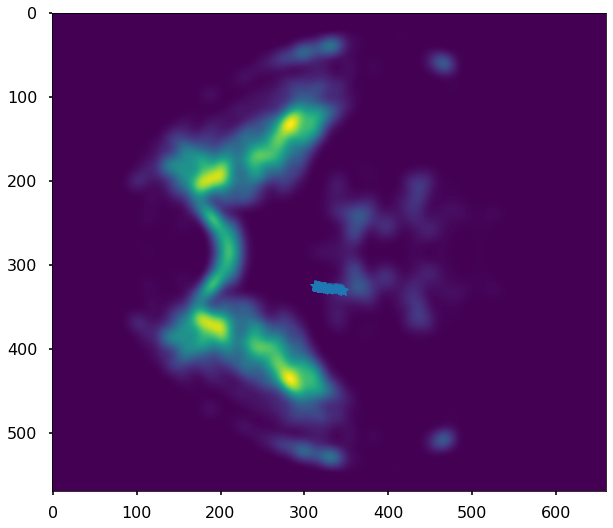

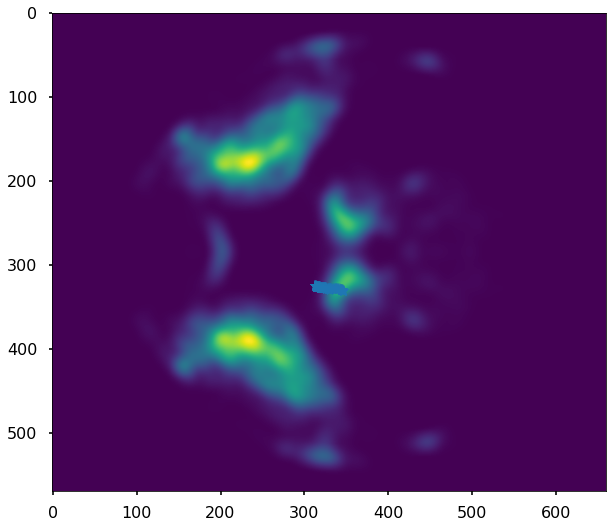

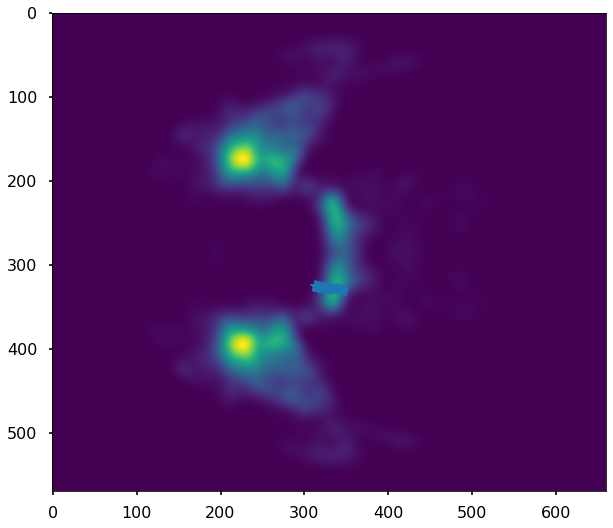

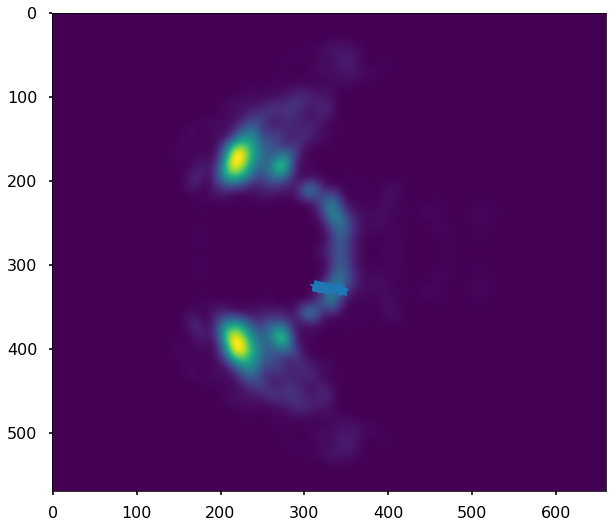

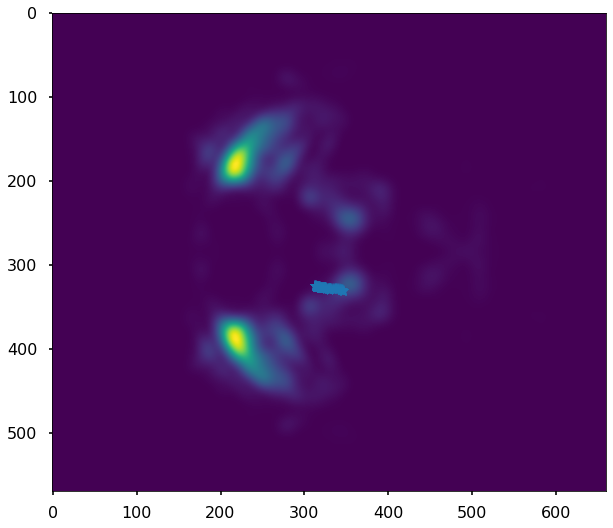

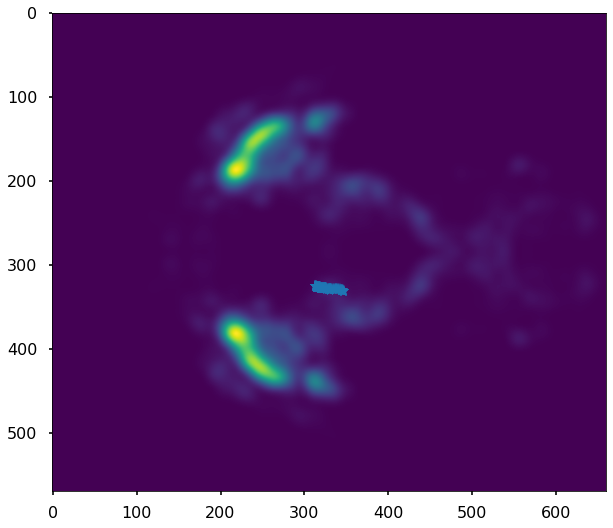

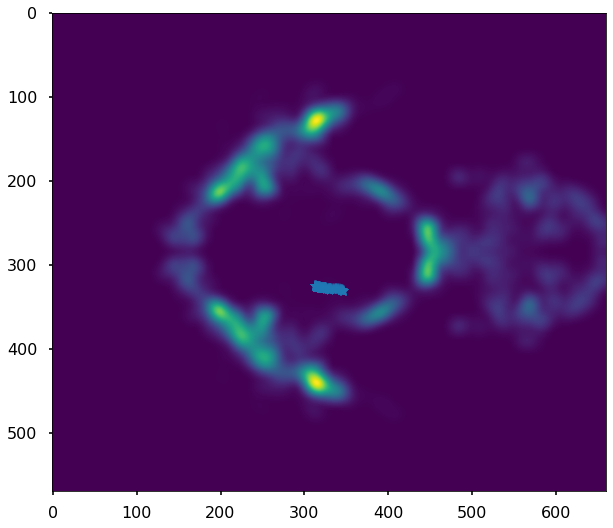

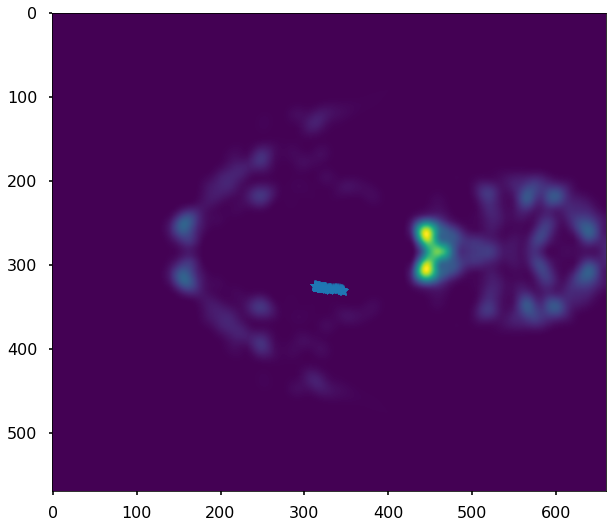

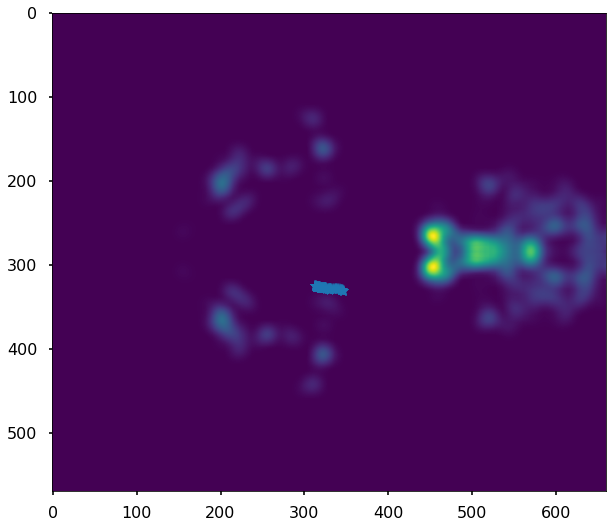

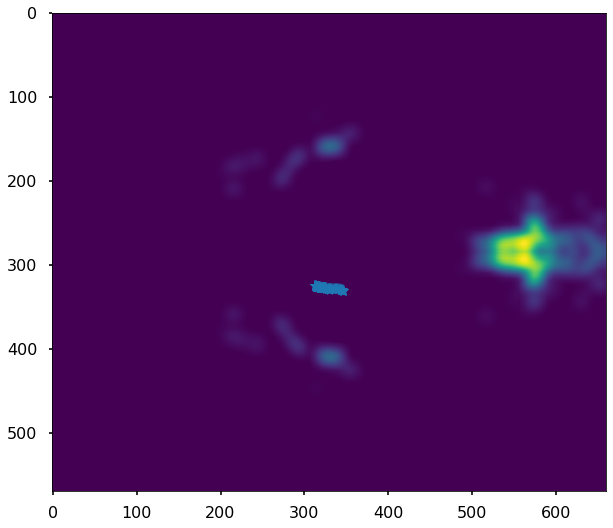

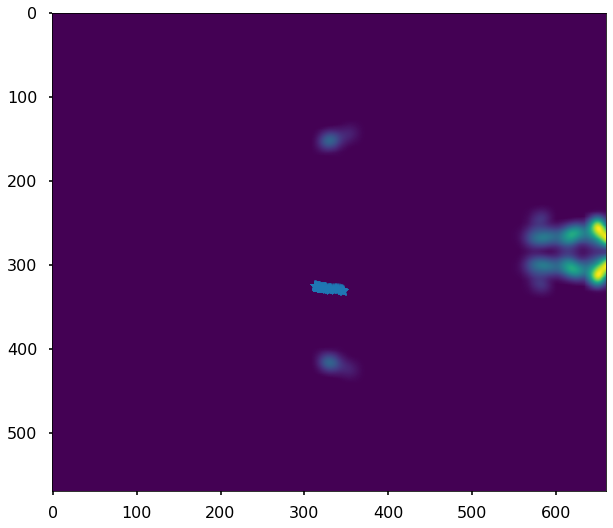

In [29]:
#Plotting Fluorescence area and CCF location of Thalamic units
for i in range(0,400,20):
    plt.imshow(vox[i,:,:])
    plt.plot(ccf_y/20,ccf_z/20,marker='*')
    plt.show()

## Checking Overlap with ALM

In [30]:
# NOW CHECKING OVERLAP FOR ALM
x_alm, y_alm, z_alm = [],[],[]

units_Data = unit_result.query(" Region == 'left ALM'  and ses_no == 1")
for i in list(units_Data.electrodes.reset_index().iloc[:,0]):
    try:
        x_ccf, y_ccf, z_ccf = get_ccf(i)
        x_alm.append(x_ccf)
        y_alm.append(y_ccf)
        z_alm.append(z_ccf)

    # Some Units have missing CCF locations
    except Exception as err:
        x.append(0)
        y.append(0)
        z.append(0)

In [31]:
len(x_alm)

211

In [32]:
%matplotlib widget

ccf_x = np.array(x_alm)
ccf_y = np.array(y_alm)
ccf_z = np.array(z_alm)

voxel_rd = 50   #Flexibility of searching criteria

V = np.array(nib.load('ALM_functionalData.nii').get_fdata())
r, c, v = np.where(V != 0)
v = -v + 114
r = r * 100
c = c * 100
v = v * 100

dorsal = np.where(ccf_y < 4000)[0]
frontal = np.where(ccf_z < 4000)[0]
frontal = np.intersect1d(dorsal, frontal)

ALMidx = []
#Condition for overlapping
for u in range(len(frontal)):
    for alm in range(len(c)):
        idx = frontal[u]
        if ccf_x[idx] >= v[alm] - voxel_rd and ccf_x[idx] < v[alm] + voxel_rd and ccf_y[idx] >= c[alm] - voxel_rd and ccf_y[idx] < c[alm] + voxel_rd and ccf_z[idx] >= r[alm] - voxel_rd and ccf_z[idx] < r[alm] + voxel_rd:
            ALMidx.append(idx)
            break

In [33]:
len(ccf_x),len(ALMidx)

(211, 28)

# CCG Implementation
## Example neuron

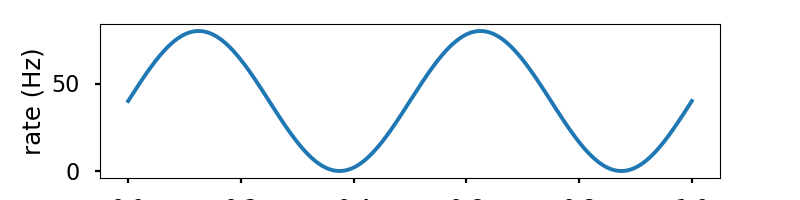

In [34]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
tmax = 1
max_rate = 80
f_osc =  2
bin_size = 1/30000
time = np.arange(0, tmax, bin_size)

rate = max_rate * (np.sin(2*np.pi*f_osc*time)+1)/2

plt.figure(figsize=(8, 2))
plt.plot(time, rate)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)');

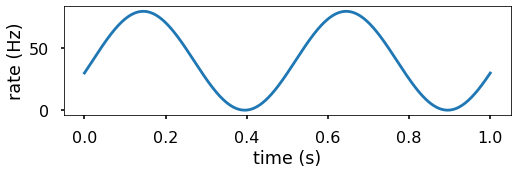

In [186]:
shift = 20/1000   #in ms
rate1 = max_rate * (np.sin(2*np.pi*f_osc*(time - shift))+1)/2
plt.figure(figsize=(8, 2))
plt.plot(time, rate1)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)');

In [187]:
list(rate).index(rate.max())*bin_size,list(rate1).index(rate1.max())*bin_size
#checking the max point of both the signals

(0.125, 0.14500000000000002)

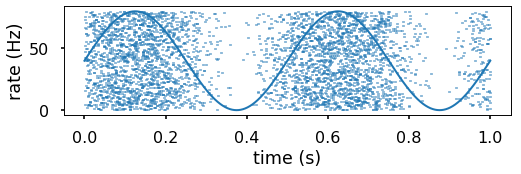

In [188]:
# Trial generator based on poisson sampling

def inhomogeneous_poisson(rate, bin_size):
    n_bins = len(rate)
    spikes = np.random.rand(n_bins) < rate * bin_size
    spike_times = np.nonzero(spikes)[0] * bin_size
    return spike_times

def inhomogeneous_poisson_generator(n_trials, rate, bin_size):
    for i in range(n_trials):
        yield inhomogeneous_poisson(rate, bin_size)

def raster_plot_multi(spike_times):
    for i, spt in enumerate(spike_times):
        plt.vlines(spt, i, i+1)
    plt.yticks([])
    
n_trials = 200

plt.figure(figsize=(8,2))
plt.plot(time, rate, lw=2)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')
spike_times = list(inhomogeneous_poisson_generator(n_trials, rate, bin_size))
plt.twinx()
raster_plot_multi(spike_times)

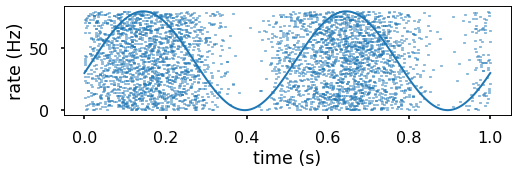

In [189]:
plt.figure(figsize=(8,2))
plt.plot(time, rate1, lw=2)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')
spike_times1 = list(inhomogeneous_poisson_generator(n_trials, rate1, bin_size))
plt.twinx()
raster_plot_multi(spike_times1)

In [190]:
#Getting Spike vector from spike times
spike_vec1 = np.zeros((n_trials, len(rate)))

spike_vec2 = np.zeros((n_trials, len(rate1)))

for j in range(0,n_trials):

    spike_vec1[j, (spike_times[j]/bin_size).astype(int) ] = 1 
    spike_vec2[j, (spike_times1[j]/bin_size).astype(int) ] = 1


In [191]:
np.array(spike_vec1).shape

(200, 30000)

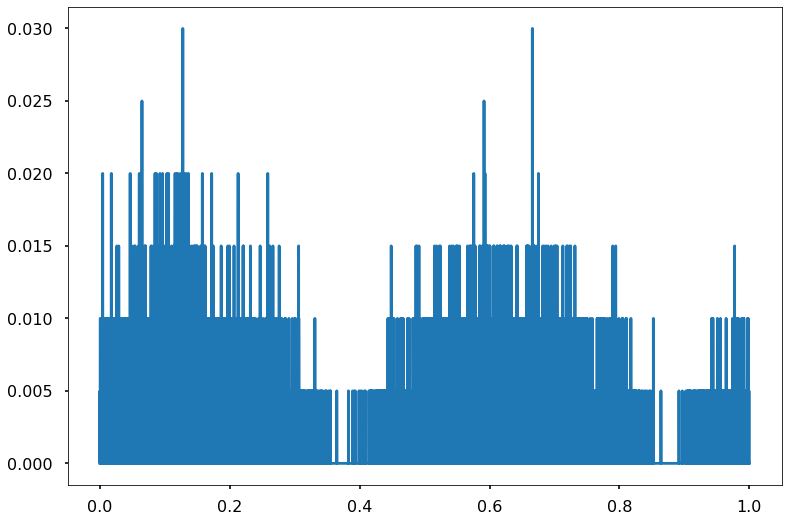

In [13]:
plt.plot(time,np.mean(spike_vec1,axis=0))
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Hz)')

# CCG Function From Paper(Siegel)

In [35]:
from scipy import stats
import scipy

def jitter(data, l):
    """
    Jittering multidemntational logical data where 
    0 means no spikes in that time bin and 1 indicates a spike in that time bin.
    """
    if len(np.shape(data))>3:
        flag = 1
        sd = np.shape(data)
        data = np.reshape(data,(np.shape(data)[0],np.shape(data)[1],len(data.flatten())/(np.shape(data)[0]*np.shape(data)[1])), order='F')
    else:
        flag = 0

    psth = np.mean(data,axis=1)
    length = np.shape(data)[0]

    if np.mod(np.shape(data)[0],l):
        data[length:(length+np.mod(-np.shape(data)[0],l)),:,:] = 0
        psth[length:(length+np.mod(-np.shape(data)[0],l)),:]   = 0

    if np.shape(psth)[1]>1:
        dataj = np.squeeze(np.sum(np.reshape(data,[l,np.shape(data)[0]//l,np.shape(data)[1],np.shape(data)[2]], order='F'), axis=0))
        psthj = np.squeeze(np.sum(np.reshape(psth,[l,np.shape(psth)[0]//l,np.shape(psth)[1]], order='F'), axis=0))
    else:
        dataj = np.squeeze(np.sum(np.reshape(data,l,np.shape(data)[0]//l,np.shape(data)[1], order='F')))
        psthj = np.sum(np.reshape(psth,l,np.shape(psth)[0]//l, order='F'))


    if np.shape(data)[0] == l:
        dataj = np.reshape(dataj,[1,np.shape(dataj)[0],np.shape(dataj)[1]], order='F');
        psthj = np.reshape(psthj,[1,np.shape(psthj[0])], order='F');

    psthj = np.reshape(psthj,[np.shape(psthj)[0],1,np.shape(psthj)[1]], order='F')
    psthj[psthj==0] = 10e-10

    corr = dataj/np.tile(psthj,[1, np.shape(dataj)[1], 1]);
    corr = np.reshape(corr,[1,np.shape(corr)[0],np.shape(corr)[1],np.shape(corr)[2]], order='F')
    corr = np.tile(corr,[l, 1, 1, 1])
    corr = np.reshape(corr,[np.shape(corr)[0]*np.shape(corr)[1],np.shape(corr)[2],np.shape(corr)[3]], order='F');

    psth = np.reshape(psth,[np.shape(psth)[0],1,np.shape(psth)[1]], order='F');
    output = np.tile(psth,[1, np.shape(corr)[1], 1])*corr

    output = output[:length,:,:]
    return output


def xcorrfft(a,b,NFFT):
    CCG = np.fft.fftshift(np.fft.ifft(np.multiply(np.fft.fft(a,NFFT), np.conj(np.fft.fft(b,NFFT)))))
    return CCG

def nextpow2(n):
    """get the next power of 2 that's greater than n"""
    m_f = np.log2(n)
    m_i = np.ceil(m_f)
    return 2**m_i

def get_ccgjitter(spikes, FR, jitterwindow):
    # spikes: neuron*ori*trial*time
    assert np.shape(spikes)[0]==len(FR)

    n_unit=np.shape(spikes)[0]
    n_t = np.shape(spikes)[3]
    # triangle function
    t = np.arange(-(n_t-1),(n_t-1))
    theta = n_t-np.abs(t)
    NFFT = int(nextpow2(2*n_t))
    target = np.array([int(i) for i in NFFT/2+np.arange((-n_t+2),n_t)])

    ccgjitter = []
    ccgraw = []
    jittered = []
    pair=0
    
    for i in np.arange(n_unit-1):
        for m in np.arange(i+1,n_unit):  
            if FR[i]>2 and FR[m]>2:
                temp1 = np.squeeze(spikes[i,:,:,:])
                temp2 = np.squeeze(spikes[m,:,:,:])
                FR1 = np.squeeze(np.mean(np.sum(temp1,axis=2), axis=1))
                FR2 = np.squeeze(np.mean(np.sum(temp2,axis=2), axis=1))
                tempccg = xcorrfft(temp1,temp2,NFFT)
                tempccg = np.squeeze(np.nanmean(tempccg[:,:,target],axis=1))

# [REMOVE] COMMENT TO GET CCG_CORRECTED and CCG_JITTER                 
#                 temp1 = np.rollaxis(np.rollaxis(temp1,2,0), 2,1)
#                 temp2 = np.rollaxis(np.rollaxis(temp2,2,0), 2,1)
#                 ttemp1 = jitter(temp1,jitterwindow);  
#                 ttemp2 = jitter(temp2,jitterwindow);
#                 tempjitter = xcorrfft(np.rollaxis(np.rollaxis(ttemp1,2,0), 2,1),np.rollaxis(np.rollaxis(ttemp2,2,0), 2,1),NFFT);  
#                 tempjitter = np.squeeze(np.nanmean(tempjitter[:,:,target],axis=1))
                
                ccgraw.append(tempccg.T/np.multiply(np.tile(np.sqrt(FR[i]*FR[m]), (len(target), 1)), 
                    np.tile(theta.T.reshape(len(theta),1),(1,len(FR1)))))
#                 jittered.append(tempjitter.T/np.multiply(np.tile(np.sqrt(FR[i]*FR[m]), (len(target), 1)), 
#                     np.tile(theta.T.reshape(len(theta),1),(1,len(FR1)))))
                
#                 ccgjitter.append((tempccg - tempjitter).T/np.multiply(np.tile(np.sqrt(FR[i]*FR[m]), (len(target), 1)), 
#                     np.tile(theta.T.reshape(len(theta),1),(1,len(FR1)))))

#     ccgjitter = np.array(ccgjitter)
    ccgraw = np.array(ccgraw)
#     jittered = np.array(jittered)
    return ccgraw,t


In [36]:
def get_ccg(spike_alm,spike_thal):
    '''
    Helper Function to match the Input data's shape to siegel paper's Function
    input's shape for siegel function->(neuron,orientation,trials,time_vec)
    
    input: takes pairs of neurons(ALM and THALAMUS)
    ouput: Return pair-wise Raw CCG and time vector
    '''
    #creating Extra axis to match the input format for Siegel CCG fuction
    new_spikes = np.expand_dims(spike_alm, axis=0)
    new_spikes = np.expand_dims(new_spikes, axis=0)
    new_spikes = np.hstack((new_spikes, new_spikes))

    new_s_spikes = np.expand_dims(spike_thal, axis=0)
    new_s_spikes = np.expand_dims(new_s_spikes, axis=0)
    new_s_spikes = np.hstack((new_s_spikes, new_s_spikes))
    
    spik = np.vstack((new_spikes, new_s_spikes))
    # spik.shape #Our (Neurons * (2 Orientation with zero degree)(Dummy axis) * trials * timestamp)
    
    #FR is firing rate for nuerons
    FR = spik.sum(-1).mean(1).mean(1)
    jitterwindow = 25/bin_size/1000  #in ms
    
    raw,tr = get_ccgjitter(spik, FR, jitterwindow= int(jitterwindow))
    return raw,tr

In [37]:
raw_ex,tr = get_ccg(spike_vec1,spike_vec2)
plt.plot(tr*bin_size,raw_ex[0].T[0])
plt.xlim(-0.1,0.1)
plt.ylim(0,2e-7)

NameError: name 'spike_vec1' is not defined

# For ALM and Thalamus


In [49]:
units_Data = unit_result.query(" Region == 'left Thalamus' and ses_no == 1")
# thal_spike = units_Data.reset_index().loc[Thalidx]    #to get overlapped neurons
thal_spike= units_Data[:20]

units_Data = unit_result.query(" Region == 'left ALM'  and ses_no == 1")
# ALM_spike = units_Data.reset_index().loc[ALMidx]      #to get overlapped neurons
ALM_spike = units_Data[:20]

In [50]:
len(thal_spike),len(ALM_spike)

(20, 20)

# Aligning spike time into trials
- ## Aligned with Sample epoch

In [51]:
after = 4.3     
before = -0.7
bin_size = 1/2000
def Spike_time(temp_unit):
    '''
    Input: Units
    
    Output: Every trial's firing rate vector AND edges(time_vector)
    
    Process: Turning Spike times into Trials
    - Aligning spike time to sample start time
    - Getting Spike time vectors
    - and returning(storing) it
    '''
 
    spike_data_l = []
    Time_vec = []
    n_trials = len(trials_Data_L)
    spike_vec1 = np.zeros((len(temp_unit),n_trials, int((1/bin_size) * (after-before)) ))
   
    
    for unit in temp_unit.reset_index().iloc[:, 0]:
        
        unit_spike_times = temp_unit["spike_times"][unit]
        trial_spikes_l = []
        i = 0
        for time in trials_Data_L['sample_start'].round(3):
            # Compute spike times relative to stimulus onset
            aligned_spikes = unit_spike_times - time
            aligned_spikes = aligned_spikes[aligned_spikes < after ]
            aligned_spikes = aligned_spikes[before < aligned_spikes]
            trial_spikes_l.append(aligned_spikes)
        spike_data_l.append(trial_spikes_l)
    for i in range(spike_vec1.shape[0]):
        for j in range(0,n_trials-1):
            spike_vec1[i, j, ((spike_data_l[i][j]-before)/bin_size).astype(int) ] = 1 
            Time_vec.append(np.multiply(np.where(spike_vec1[i][j] == 1),bin_size)+before)
    return spike_vec1,Time_vec
    
spike_alm,time_alm = Spike_time(ALM_spike)
spike_thal,time_thal = Spike_time(thal_spike)

- ## Aligned with Go que

In [52]:
after = 3.0     
before = -3.0
bin_size = 1/2000
def Spike_time(temp_unit):
    '''
    Input: Units
    
    Output: Every trial's firing rate vector AND edges(time_vector)
    
    Process: Turning Spike times into Trials
    - Aligning spike time to go start time
    - Getting Spike time vectors
    - and returning(storing) it
    '''
 
    spike_data_l = []
    Time_vec = []
    n_trials = len(trials_Data_L)
    spike_vec1 = np.zeros((len(temp_unit),n_trials, int((1/bin_size) * (after-before)) ))
   
    
    for unit in temp_unit.reset_index().iloc[:, 0]:
        
        unit_spike_times = temp_unit["spike_times"][unit]
        trial_spikes_l = []
        i = 0
        for time in trials_Data_L['go_start'].round(3):
            # Compute spike times relative to go onset
            aligned_spikes = unit_spike_times - time
            aligned_spikes = aligned_spikes[aligned_spikes < after ]
            aligned_spikes = aligned_spikes[before < aligned_spikes]
            trial_spikes_l.append(aligned_spikes)
        spike_data_l.append(trial_spikes_l)
    for i in range(spike_vec1.shape[0]):
        for j in range(0,n_trials):
            spike_vec1[i, j, ((spike_data_l[i][j]-before)/bin_size).astype(int) ] = 1 
            Time_vec.append(np.multiply(np.where(spike_vec1[i][j] == 1),bin_size)+before)
    return spike_vec1,Time_vec
    
spike_alm,time_alm = Spike_time(ALM_spike)
spike_thal,time_thal = Spike_time(thal_spike)

In [53]:
spike_alm.shape

(20, 242, 12000)

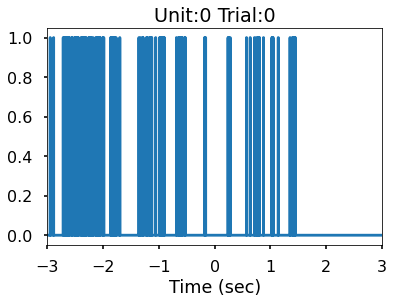

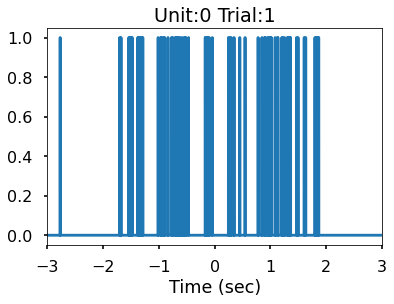

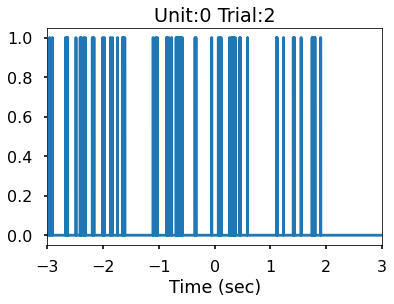

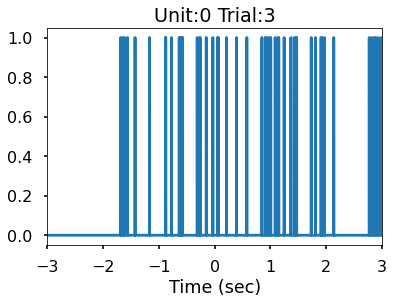

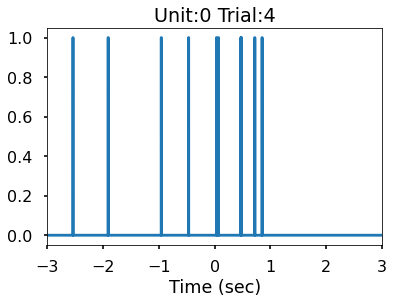

In [54]:
for i in range(5):
    plt.figure()
    plt.plot(np.arange(0,6,bin_size)-3,spike_alm[0][i])
    plt.title("Unit:0 Trial:%s"%i)
    plt.xlim(-3,3)    
    plt.xlabel('Time (sec)')
#     plt.savefig('Unit_1_Trial_%s.png' % (i))
    plt.show()

# Calculate CCG

In [55]:
%matplotlib inline

raw = []
for i in range(len(spike_alm)):
    for j in range(len(spike_thal)):
        r,tr = get_ccg(spike_alm[i],spike_thal[j])
        raw.append(r)


In [67]:
np.array(raw).shape

C:\Users\smit3\AppData\Local\Temp/ipykernel_17548/3306598.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(raw).shape


(846,)

In [66]:
# PICKEL FILES BELOW ARE CENTERED ON SAMPLE EPOCH
import pickle
# bin_size = 1/2000
# with open('ALM_THAL_440959_with0.5ms.pkl', 'wb') as f:
#     pickle.dump(raw, f)

with open('ALM_THAL_440959_with0.5ms.pkl', 'rb') as f: 
    raw = pickle.load(f)

In [83]:
raw[423].shape

(1, 4798, 2)

In [94]:
n_t = 2400
bin_size = 1/2000
tr = np.arange(-(n_t-1),(n_t-1))

def get_slice(ccgs, rang1,rang2):
    # Getting Perticular range of data
    return (ccgs[0].T[0][int((n_t + (rang1/1000/bin_size))): int((n_t + (rang2/1000/bin_size)))])

def get_peak(raws):
    '''
    Plotting Graphs whose peak in range of [-10,10]ms is atleast 6 time grater
    than Standard deviation of range [-50,50]ms (Ranges are defined according to Siegel paper)
    ''' 
    j = 0
    for i in range(len(raws)):
        if raws[i].shape[0] != 0:
            sd=np.std(get_slice(raws[i],-50,50))
            rel_max = np.max(get_slice(raws[i],-10,10))
            rel_min = np.min(get_slice(raws[i],-10,10))
            relpeak = rel_max-rel_min
            if float(relpeak/sd)>5.7:
                j = j+1
                plt.figure()
                plt.plot(tr*bin_size,raws[i][0].T[0])
                plt.xlim(-0.05,0.05)
                plt.ylim(0,rel_max*1.2)
                plt.xticks((range(1,11)-5)/100)
                plt.xlabel("Time(sec)")
#                 plt.savefig('ALM_THAL_0.5ms_%s.png' % (i))
                plt.show()
    print(j)

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


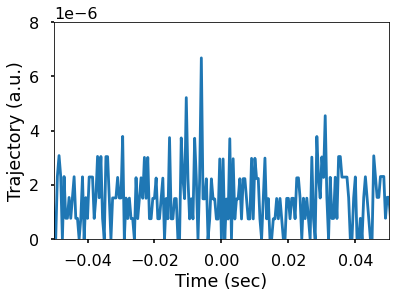

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


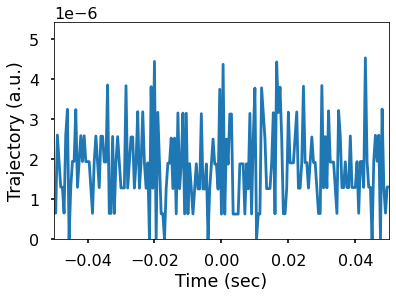

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


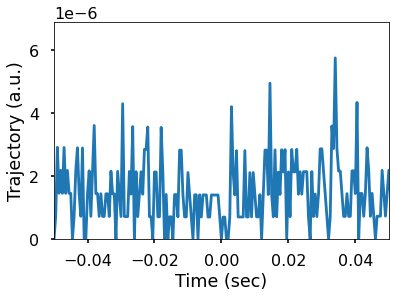

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


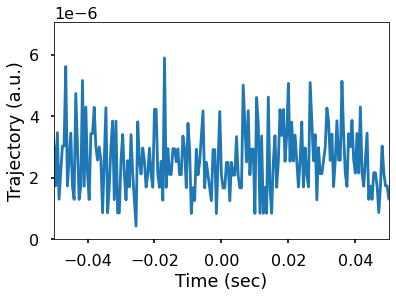

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


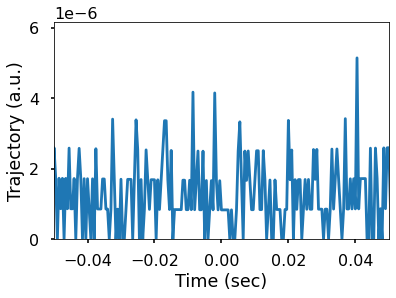

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


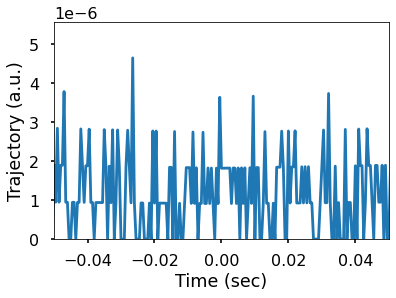

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


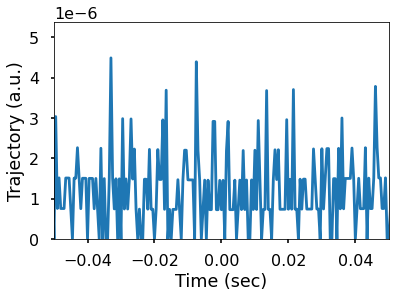

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


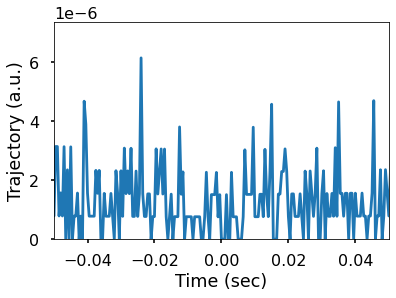

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


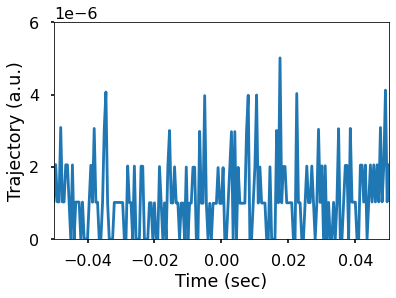

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


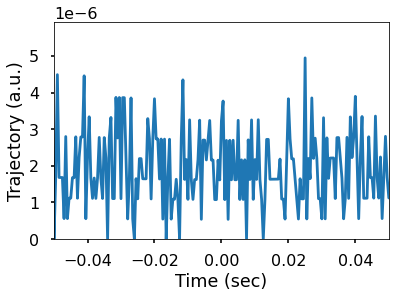

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


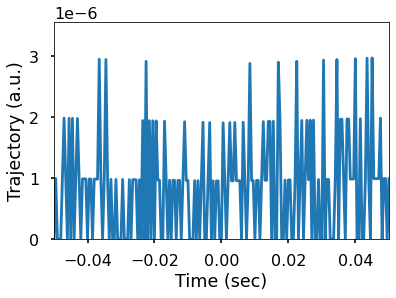

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


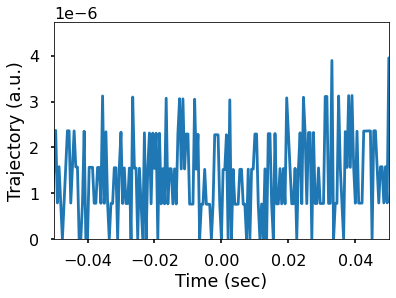

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


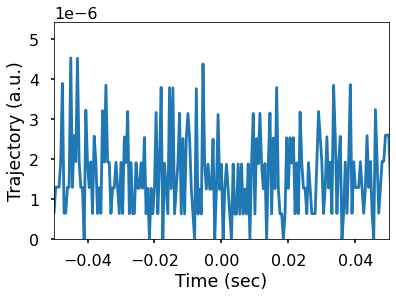

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


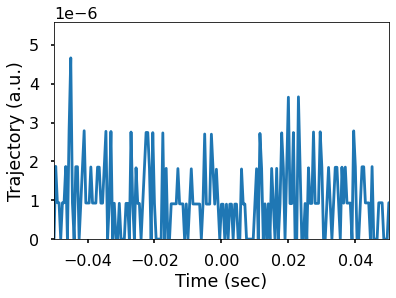

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


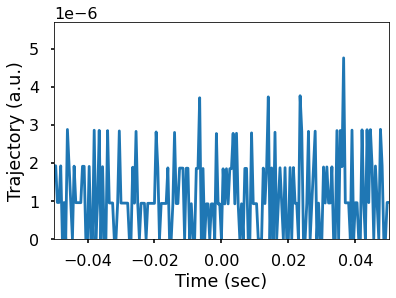

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


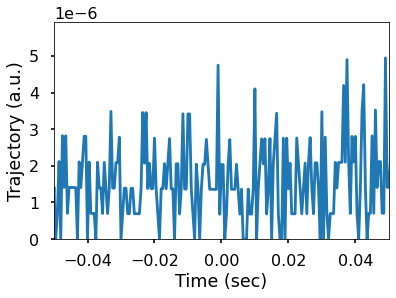

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


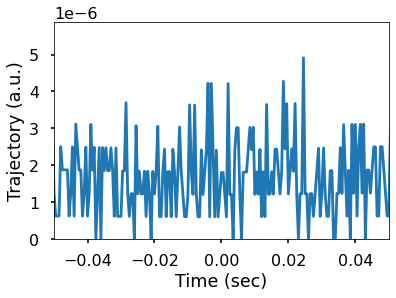

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


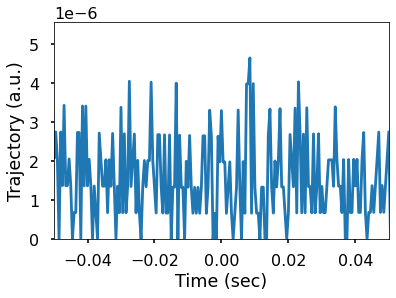

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


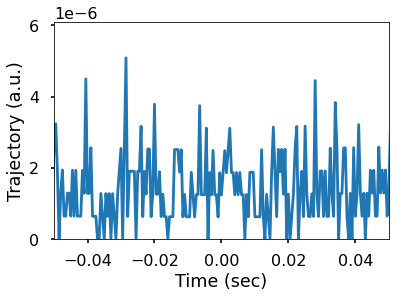

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


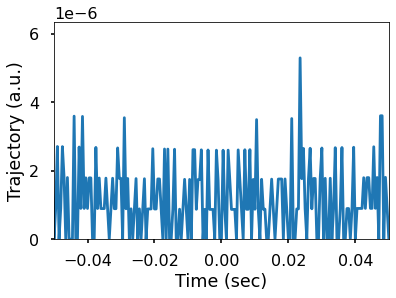

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


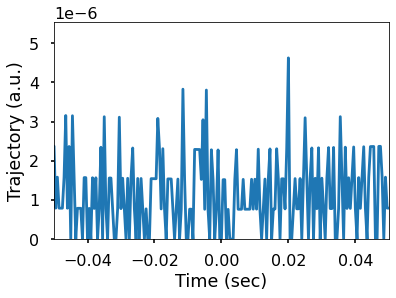

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


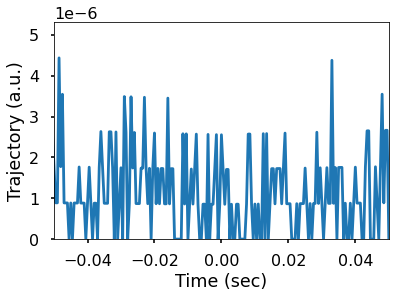

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


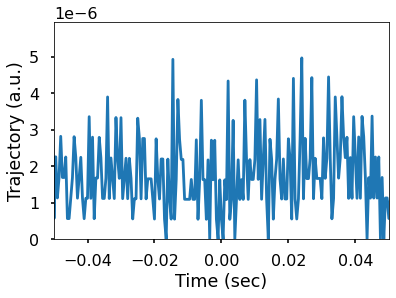

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


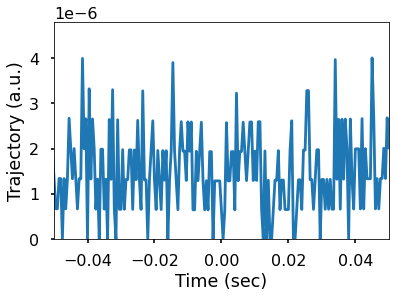

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


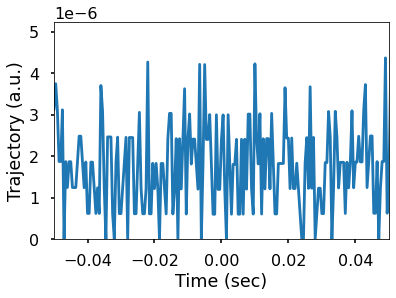

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


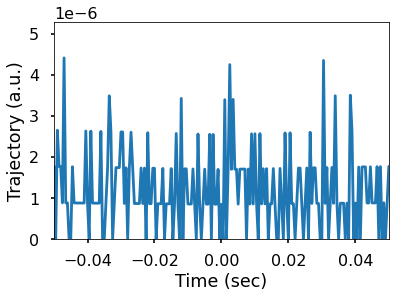

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


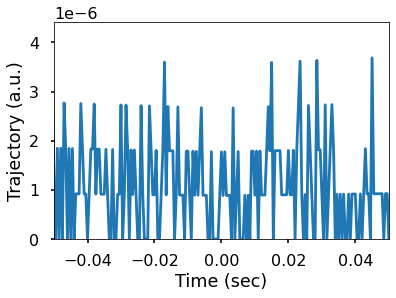

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


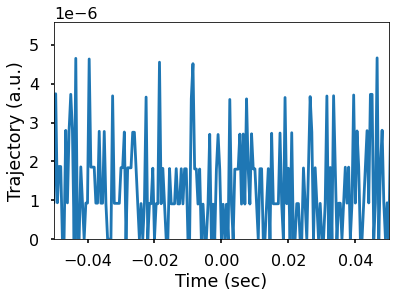

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


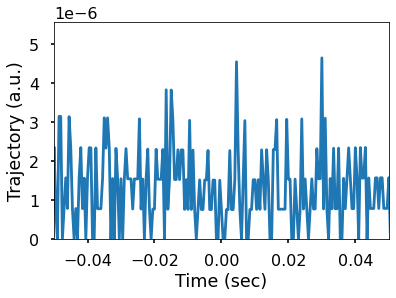

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


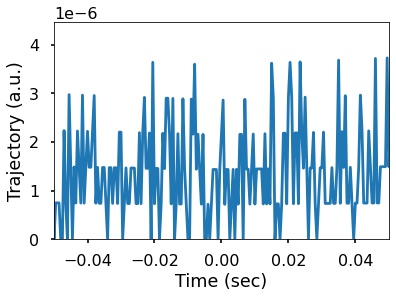

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


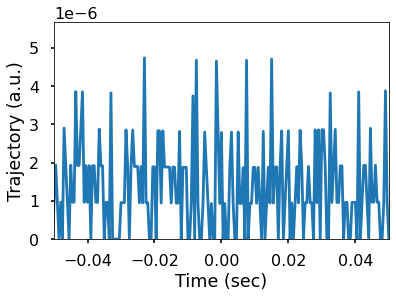

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


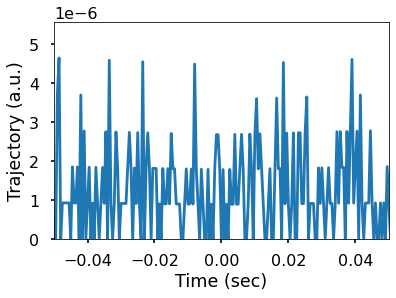

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


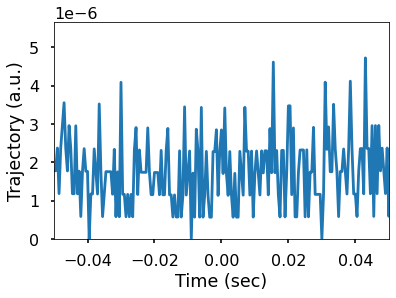

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


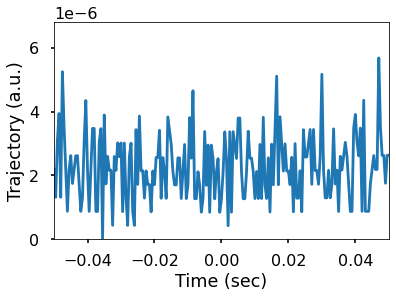

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


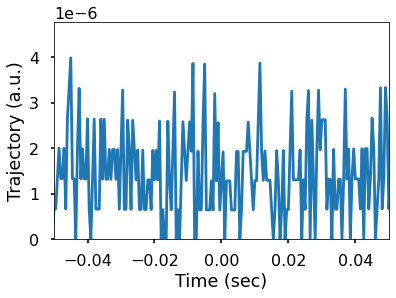

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [85]:
for i in range(len(raw)):
    if raw[i].shape[0] != 0:
        plt.figure()
        plt.plot(tr*bin_size,raw[i][0].T[0])
        plt.xlim(-0.05,0.05)
        plt.ylim(0,np.max(get_slice(raw[i],-50,50))*1.2)
        plt.xlabel('Time (sec)')
        plt.ylabel('Trajectory (a.u.)')
        plt.show()

C:\Users\smit3\AppData\Local\Temp/ipykernel_17548/482371474.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  if float(relpeak/sd)>5.7:
G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
G:\Anaconda\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


TypeError: unsupported operand type(s) for -: 'range' and 'int'

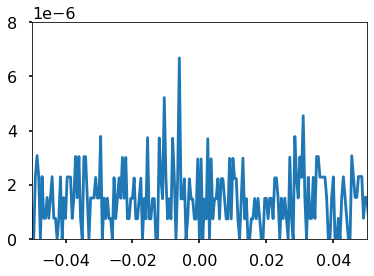

In [95]:
get_peak(raw)

# Controlled Env
- ### Aligning spike time into trials

In [106]:
units_Data = unit_result.query(" Region == 'left Thalamus'")
thal_spike = units_Data[:1]

after = 4.3     
before = -0.7
bin_size = 1/30000
def Spike_time(temp_unit,i):
     '''
     input: Neuron(unit), and Flag variable i(which decides time lag or not)
     output: Spike vector(Firing Rate) of input neuron based on flag
     
     process:
     - Spike times are centered on sample start
     - Convert Times into trials
     - Return Shift the time by some offset if flag i=1
     - Return Original Firing Rate vec as output if flag i=0
     '''
    spike_data_l = []
    n_trials = len(trials_Data_L)
    spike_vec1 = np.zeros((len(temp_unit),n_trials, int((1/bin_size) * (after-before)) ))
   
    # Creating Example neuron with time shift
    for unit in temp_unit.reset_index().iloc[:,0]:
        if(i==1):
            unit_spike_times = np.asarray(temp_unit["spike_times"][unit]) + 0.005 
        else:
            unit_spike_times = np.asarray(temp_unit["spike_times"][unit])
        trial_spikes_l = []
        i = 0
        for time in trials_Data_L['sample_start'].round(3):
            # Compute spike times relative to stimulus onset
        
            aligned_spikes = unit_spike_times - time
            aligned_spikes = aligned_spikes[aligned_spikes < after ]
            aligned_spikes = aligned_spikes[before < aligned_spikes]
            trial_spikes_l.append(aligned_spikes)
        spike_data_l.append(trial_spikes_l)
    for i in range(spike_vec1.shape[0]):
        for j in range(0,n_trials-1):
            spike_vec1[i, j, ((spike_data_l[i][j]-before)/bin_size).astype(int) ] = 1 
    return spike_vec1
    
spike_alm = Spike_time(thal_spike,0)
spike_thal = Spike_time(thal_spike,1)

In [108]:
#creating Extra axis to match the input format for Siegel CCG fuction
new_spikes = np.expand_dims(spike_alm, axis=1)
new_spikes = np.hstack((new_spikes, new_spikes))

new_s_spikes = np.expand_dims(spike_thal, axis=1)
new_s_spikes = np.hstack((new_s_spikes, new_s_spikes))

spik = np.vstack((new_spikes, new_s_spikes))

FR = spik.sum(-1).mean(1).mean(1)
spik.shape

(2, 2, 242, 150000)

In [110]:
tr = np.arange(-(spike_alm[0][0].shape[0]-1),(spike_alm[0][0].shape[0]-1))
theta = spike_alm[0][0].shape[0] -np.abs(tr)

jitterwindow = 25/bin_size/1000  #in ms
rawcon,tr = get_ccgjitter(spik, FR, jitterwindow= int(jitterwindow))

In [111]:
rawcon.shape

(1, 299998, 2)

G:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Time(s)')

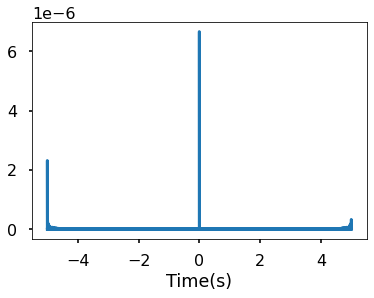

In [112]:
plt.plot(tr*bin_size,rawcon[0].T[0])
plt.xlim(-0.1,0.1)
plt.xlabel("Time(s)")